Here we will be working on real world customer reviews. We will have 2 goals here,


1.   Performing sentiment analysis

2.   Selecting valuable Customer Reviews which can help to improve user experience



#  **Sentiment Analysis**

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/ML_DATASETS/Customer_support_data.csv')
df['Customer Remarks']

Buffered data was truncated after reaching the output size limit.

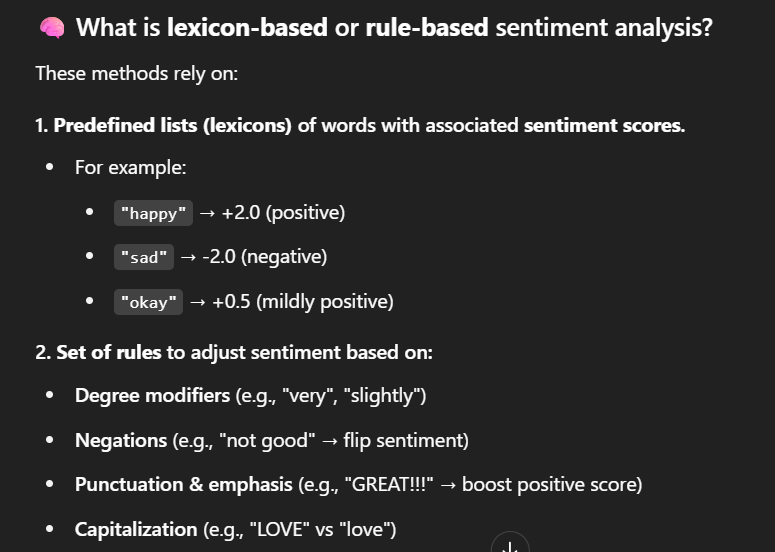

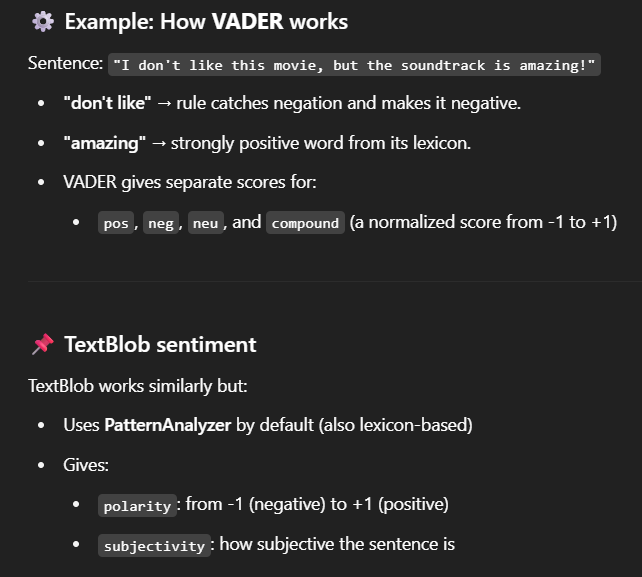

**✅ 1. VADER (Valence Aware Dictionary and sEntiment Reasoner)**

🔧 Type: Rule-based + Lexicon-based

🧠 Is it trained?

No, not in the machine learning sense.









In [ ]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

# Drop rows where 'Customer Remarks' is NaN
df = df.dropna(subset=['Customer Remarks'])

# Define sentiment classification function
def classify_sentiment(text):
    score = sia.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply classification
df['Sentiment'] = df['Customer Remarks'].apply(classify_sentiment)

# View result
print(df['Sentiment'].value_counts())

**TextBlob**

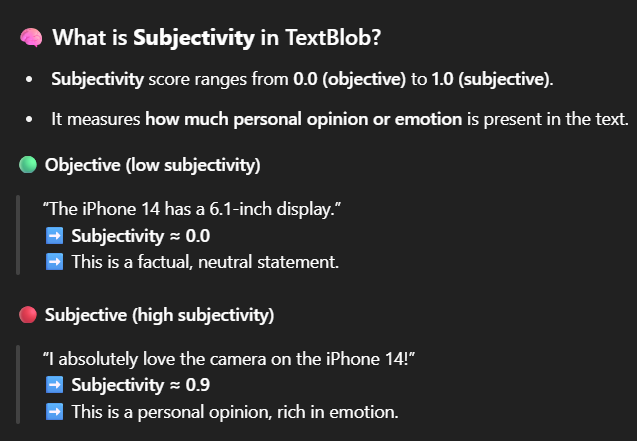

Textblob gives both polarity and subjectivity, sujectivity is helpful in emotional sentiment analysis.

In [ ]:
!pip install -q textblob
import pandas as pd
from textblob import TextBlob

df = df.dropna(subset=['Customer Remarks'])

# Define sentiment classification
def classify_sentiment_tb(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

df['Sentiment_TextBlob'] = df['Customer Remarks'].apply(classify_sentiment_tb)

# View counts
print(df['Sentiment_TextBlob'].value_counts())


As compared to VADER, no. of positive and negative has decreased and neutral has incresed. lets for the these reviews, understanding which is performing better.

**Classical ML**

(TF-IDF + Logistic Regression)

In [ ]:
!pip install -q scikit-learn

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Load dataset with labels
# df = pd.read_csv('your_labeled_data.csv')  # Must include 'Customer Remarks' and 'Sentiment' columns

df = df.dropna(subset=['Customer Remarks'])
X = df['Customer Remarks']
y = df['Sentiment_TextBlob']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize
vectorizer = TfidfVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

# Train model
model = LogisticRegression()
model.fit(X_train_vect, y_train)

# Predict
y_pred = model.predict(X_test_vect)

# Evaluation
print(classification_report(y_test, y_pred))


In [ ]:
# For classical ML models
!pip install -q scikit-learn

# For XGBoost
!pip install -q xgboost


import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score

# Models
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [ ]:
from sklearn.metrics import accuracy_score

models = {
    "Logistic Regression": LogisticRegression(),
    "Multinomial NB": MultinomialNB(),
    "Linear SVM": LinearSVC(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    # "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),         here we need labels from 0 indexing
    "SGDClassifier": SGDClassifier(loss='hinge', penalty='l2', max_iter=1000),
}

for name, model in models.items():
    model.fit(X_train_vect, y_train)
    y_pred = model.predict(X_test_vect)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name}: Accuracy = {acc:.4f}")
    print(classification_report(y_test, y_pred))
    print('-' * 80)


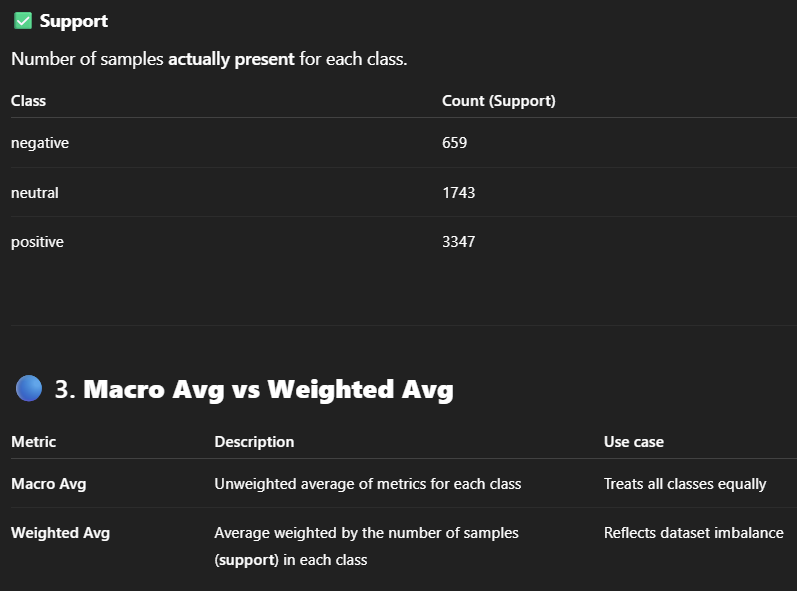

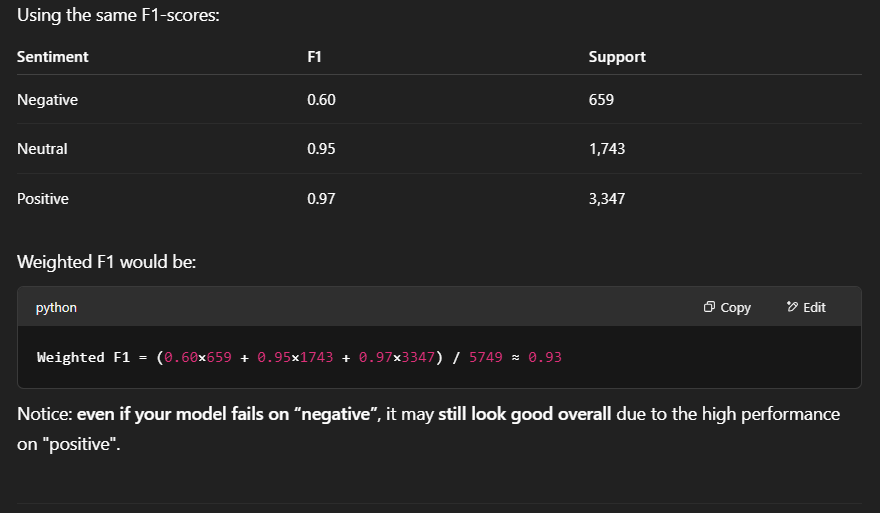

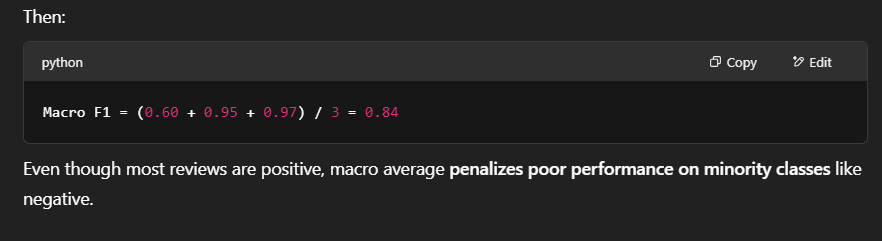

Macro avg want to give importance to minority class too, here it reduces to F1 due to low performance on minority class, but Weighted avg takes the number of samples present for each class into account, it is like if majority class is performing good; then I am good. This weighted avg also used to understand the performance of sample in prodution(actually our sample/dataset is true reflection of real world, where we want our model to work)

**DistilBERT via HuggingFace Transformers (No Training)**

In [ ]:
!pip install -q transformers

from transformers import pipeline
import pandas as pd

df = df.dropna(subset=['Customer Remarks'])

# Load sentiment pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
# sentiment_pipeline = pipeline("sentiment-analysis", model="microsoft/MiniLM-L6-H384-uncased")       --- lighter model

# Apply to a sample or full dataset (limit for demo)
df_sample = df.head(1000)  # To avoid long processing in free Colab

# Analyze sentiments
results = sentiment_pipeline(df_sample['Customer Remarks'].tolist(), truncation=True)

# Extract label only
df_sample['Sentiment_DistilBERT'] = [res['label'].lower() for res in results]

# View counts
print(df_sample['Sentiment_DistilBERT'].value_counts())


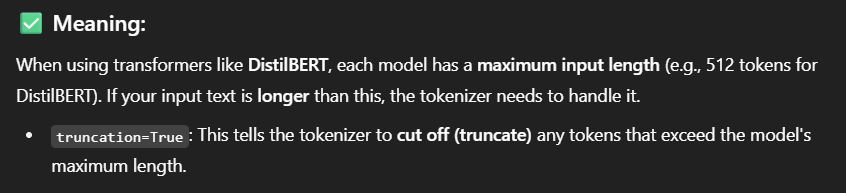

There are few other models like Longformer, BigBird; which have high token limit; but Longformer/BigBird models aren't pre-finetuned for sentiment, so we may get poor results if directly go for inference/prediction.

✅ Step-by-step: Add VADER and TextBlob to df_sample

In [ ]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# VADER function
def vader_sentiment(text):
    score = sia.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# TextBlob function
def textblob_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.05:
        return 'positive'
    elif polarity < -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply both only on df_sample (first 1000 rows)
df_sample['Sentiment_VADER'] = df_sample['Customer Remarks'].apply(vader_sentiment)
df_sample['Sentiment_TextBlob'] = df_sample['Customer Remarks'].apply(textblob_sentiment)


✅ Show Sample of Side-by-Side Results

In [ ]:

# Show only rows where at least one model disagrees with another
disagree = df_sample[(df_sample['Sentiment_DistilBERT'] != df_sample['Sentiment_VADER']) |
                     (df_sample['Sentiment_DistilBERT'] != df_sample['Sentiment_TextBlob']) |
                     (df_sample['Sentiment_VADER'] != df_sample['Sentiment_TextBlob'])]

# Show sample of 10 disagreements
disagree[['Customer Remarks', 'Sentiment_VADER', 'Sentiment_TextBlob', 'Sentiment_DistilBERT']].sample(100, random_state=42)


Don't sell company defective items.	positive -	neutral -	positive

🧠 Why Did DistilBERT Say "Positive"?
DistilBERT is a transformer-based model trained on SST-2 (Stanford Sentiment Treebank), which was focused mostly on movie reviews. Here's why it might get confused:

It sees the word "sell" — a neutral-to-positive verb in business contexts.

It sees "company" — neutral.

It sees "defective" — negative, but the phrase “don’t sell” might confuse it.

Transformers aren’t great with negation if not explicitly fine-tuned on domain-specific data (e.g., customer complaints, not movie reviews).



In [ ]:
import pandas as pd

# Display all columns
pd.set_option('display.max_columns', None)

# Display all rows (optional, use with care for large DataFrames)
pd.set_option('display.max_rows', None)

# Don't truncate column width (show full text)
pd.set_option('display.max_colwidth', None)

# Optional: display full width in interactive tables
pd.set_option('display.expand_frame_repr', False)


😎 **Running better models i.e. pretrained on customer reviews**

In [ ]:
!pip install -q transformers
import pandas as pd
from transformers import pipeline


In [ ]:
# Load your dataset
df = pd.read_csv('/content/drive/MyDrive/ML_DATASETS/Customer_support_data.csv')
df = df.dropna(subset=['Customer Remarks'])
df_sample = df.head(1000)  # Keep same size for fair comparison


**🔷 1. Kaludi/Reviews-Sentiment-Analysis (Fine-tuned on customer reviews)**

In [ ]:
kaludi_pipeline = pipeline("sentiment-analysis", model="Kaludi/Reviews-Sentiment-Analysis")

kaludi_results = kaludi_pipeline(df_sample['Customer Remarks'].tolist(), truncation=True)

df_sample['Sentiment_Kaludi'] = [res['label'].lower() for res in kaludi_results]
print(df_sample['Sentiment_Kaludi'].value_counts())


**🔷 2. nlptown/bert-base-multilingual-uncased-sentiment (Works well on reviews in multiple languages)**.

This model gives star ratings (1 to 5 stars), which you can map to sentiments:

1–2 stars → negative

3 stars → neutral

4–5 stars → positive

In [ ]:
nlptown_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

nlptown_results = nlptown_pipeline(df_sample['Customer Remarks'].tolist(), truncation=True)

def convert_star_to_sentiment(label):
    stars = int(label.split()[0])
    if stars <= 2:
        return 'negative'
    elif stars == 3:
        return 'neutral'
    else:
        return 'positive'

df_sample['Sentiment_NLPTown'] = [convert_star_to_sentiment(res['label']) for res in nlptown_results]
print(df_sample['Sentiment_NLPTown'].value_counts())


**🔷 3. cardiffnlp/twitter-roberta-base-sentiment (Roberta trained on Twitter & review-like data)**

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np

# Load tokenizer & model
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

labels = ['negative', 'neutral', 'positive']

def roberta_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    with torch.no_grad():
        logits = model(**inputs).logits
    probs = torch.nn.functional.softmax(logits, dim=1)
    pred = torch.argmax(probs, dim=1).item()
    return labels[pred]

df_sample['Sentiment_Roberta'] = df_sample['Customer Remarks'].apply(roberta_sentiment)
print(df_sample['Sentiment_Roberta'].value_counts())


**✅ Reapply DistilBERT on df_sample**

In [ ]:
# Load DistilBERT sentiment pipeline
distilbert_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# Truncate reviews to avoid length errors
results_distilbert = distilbert_pipeline(df_sample['Customer Remarks'].tolist(), truncation=True)

# Add results to DataFrame
df_sample['Sentiment_DistilBERT'] = [res['label'].lower() for res in results_distilbert]


**✅ Now View Comparison**

In [ ]:
# Compare sentiment outputs from all models
df_sample[['Customer Remarks',
           'Sentiment_DistilBERT',
           'Sentiment_Kaludi',
           'Sentiment_NLPTown',
           'Sentiment_Roberta']].head(100)



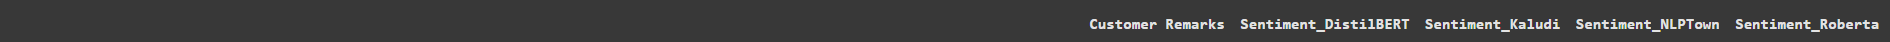

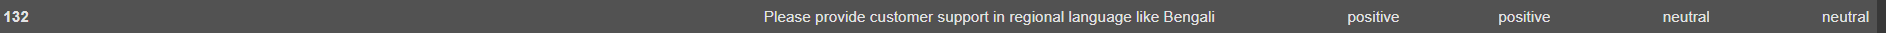

Such valuable feedbacks should be handled later which can be resolved easily; and helps the customers.

While going for sentiment analysis, we can ensemble these models which are fine-tuned on customer reviews.

**Problems**


*   how to handle if sentence is both postive and negative. positive for one entity and negative for another. e.g this phone has great camera but poor battery.




# **Finetuning model on our own review dataset**

**✅ Step-by-Step Guide: Fine-Tune DistilBERT on Customer Reviews**

🔧 Step 1: Install Dependencies

In [ ]:
!pip install -q transformers datasets accelerate evaluate


📦 Step 2: Prepare Your Data

Ensure your dataset has two columns: text (the review) and label (0 = negative, 1 = neutral, 2 = positive).

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/ML_DATASETS/Customer_support_data.csv')
df = df.head(1000)
# Drop NaNs and ensure all inputs are strings
df = df.dropna(subset=['Customer Remarks'])
# df['Customer Remarks'] = df['Customer Remarks'].astype(str)

Preparing our true labels using a pretrained-model

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np

# Load tokenizer & model
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

labels = ['negative', 'neutral', 'positive']

def roberta_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    with torch.no_grad():
        logits = model(**inputs).logits
    probs = torch.nn.functional.softmax(logits, dim=1)
    pred = torch.argmax(probs, dim=1).item()
    return labels[pred]

df['Sentiment_Roberta'] = df['Customer Remarks'].apply(roberta_sentiment)
print(df['Sentiment_Roberta'].value_counts())


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Sentiment_Roberta
positive    151
neutral      81
negative     80
Name: count, dtype: int64


In [ ]:
df.columns

Index(['Unique id', 'channel_name', 'category', 'Sub-category',
       'Customer Remarks', 'Order_id', 'order_date_time', 'Issue_reported at',
       'issue_responded', 'Survey_response_Date', 'Customer_City',
       'Product_category', 'Item_price', 'connected_handling_time',
       'Agent_name', 'Supervisor', 'Manager', 'Tenure Bucket', 'Agent Shift',
       'CSAT Score', 'Sentiment_Roberta'],
      dtype='object')

In [ ]:
import pandas as pd

# Clean and map sentiment labels
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df = df.dropna(subset=['Customer Remarks', 'Sentiment_Roberta'])
df = df[df['Sentiment_Roberta'].isin(label_mapping)]
df['label'] = df['Sentiment_Roberta'].map(label_mapping)
df_new = df[['Customer Remarks', 'label']].rename(columns={'Customer Remarks': 'text'})       #------  imp


In [ ]:
df.columns

Index(['Unique id', 'channel_name', 'category', 'Sub-category',
       'Customer Remarks', 'Order_id', 'order_date_time', 'Issue_reported at',
       'issue_responded', 'Survey_response_Date', 'Customer_City',
       'Product_category', 'Item_price', 'connected_handling_time',
       'Agent_name', 'Supervisor', 'Manager', 'Tenure Bucket', 'Agent Shift',
       'CSAT Score', 'Sentiment_Roberta', 'label'],
      dtype='object')

In [ ]:
df_new.columns

Index(['text', 'label'], dtype='object')

📁 Step 3: Load to Hugging Face Dataset Format

In [ ]:
from datasets import Dataset

dataset = Dataset.from_pandas(df_new)
dataset = dataset.train_test_split(test_size=0.2)


🤗 Step 4: Tokenize with a Pretrained Tokenizer

In [ ]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize(example):
    return tokenizer(example["text"], truncation=True)

tokenized_dataset = dataset.map(tokenize, batched=True)


Map:   0%|          | 0/249 [00:00<?, ? examples/s]

Map:   0%|          | 0/63 [00:00<?, ? examples/s]

⚙️ Step 5: Define Model and Training Configuration

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🧪 Step 6: Evaluation Metric

In [ ]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)


🚀 Step 7: Training

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="sentiment-model",
    eval_strategy="steps",    #updated to eval_strategy (previously evalution_strategy form gpt)
    save_strategy="steps",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()


<ipython-input-12-30232d6a894a>:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: aayyuusshh369 (aayyuusshh369-iit-kharagpur) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss


TrainOutput(global_step=48, training_loss=0.8789873123168945, metrics={'train_runtime': 325.3969, 'train_samples_per_second': 2.296, 'train_steps_per_second': 0.148, 'total_flos': 11652164370072.0, 'train_loss': 0.8789873123168945, 'epoch': 3.0})

**📤 Step 8: Save Your Model**

In [ ]:
model.save_pretrained("/content/drive/MyDrive/ML_DATASETS/finetuned-distilbert-sentiment")
tokenizer.save_pretrained("/content/drive/MyDrive/ML_DATASETS/finetuned-distilbert-sentiment")


('/content/drive/MyDrive/ML_DATASETS/finetuned-distilbert-sentiment/tokenizer_config.json',
 '/content/drive/MyDrive/ML_DATASETS/finetuned-distilbert-sentiment/special_tokens_map.json',
 '/content/drive/MyDrive/ML_DATASETS/finetuned-distilbert-sentiment/vocab.txt',
 '/content/drive/MyDrive/ML_DATASETS/finetuned-distilbert-sentiment/added_tokens.json',
 '/content/drive/MyDrive/ML_DATASETS/finetuned-distilbert-sentiment/tokenizer.json')

Using our trained model, for prediction.Since our purpose  is implementation only; here we have simply tested on train_data i.e. simply compared our true_labels with fine_tuned_distilbert prediction.

In [ ]:
df.columns

Index(['Unique id', 'channel_name', 'category', 'Sub-category',
       'Customer Remarks', 'Order_id', 'order_date_time', 'Issue_reported at',
       'issue_responded', 'Survey_response_Date', 'Customer_City',
       'Product_category', 'Item_price', 'connected_handling_time',
       'Agent_name', 'Supervisor', 'Manager', 'Tenure Bucket', 'Agent Shift',
       'CSAT Score', 'Sentiment_Roberta', 'label'],
      dtype='object')

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import pandas as pd
import torch.nn.functional as F

# Load your custom fine-tuned model
model_path = "/content/drive/MyDrive/ML_DATASETS/finetuned-distilbert-sentiment"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# You can define your own labels depending on your fine-tuning (typically ['negative', 'positive'] or ['negative', 'neutral', 'positive'])
labels = ['negative', 'positive','neutral']  # Change this if your fine-tuning included neutral

# Define the prediction function
def distilbert_custom_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        logits = model(**inputs).logits
    probs = F.softmax(logits, dim=1)
    pred = torch.argmax(probs, dim=1).item()
    return labels[pred]

# Apply to your DataFrame
df['Sentiment_CustomDistilBERT'] = df['Customer Remarks'].apply(distilbert_custom_sentiment)

# See sentiment distribution
print(df['Sentiment_CustomDistilBERT'].value_counts())


Sentiment_CustomDistilBERT
neutral     234
negative     46
positive     32
Name: count, dtype: int64


In [ ]:
import pandas as pd

# Display all columns
pd.set_option('display.max_columns', None)

# Display all rows (optional, use with care for large DataFrames)
pd.set_option('display.max_rows', None)

# Don't truncate column width (show full text)
pd.set_option('display.max_colwidth', None)

# Optional: display full width in interactive tables
pd.set_option('display.expand_frame_repr', False)

In [ ]:
# Compare sentiment outputs from all models
df[['Customer Remarks', 'Sentiment_Roberta', 'Sentiment_CustomDistilBERT']].head(100)

,Customer Remarks,Sentiment_Roberta,Sentiment_CustomDistilBERT
7,Very good,positive,neutral
8,Shopzilla app and it's all coustomer care services is very good service provided all time,positive,neutral
11,Very bad,negative,neutral
17,Something,neutral,neutral
19,All good,positive,neutral
21,Good,positive,neutral
23,Godd job,negative,neutral
25,Issue not resolved pathetic service,negative,negative
27,Excellent,neutral,neutral
29,Very good,positive,neutral


In [ ]:
# !pip install -U transformers

# import transformers
# print(transformers.__version__)


In [ ]:
!pip install -q wordcloud matplotlib


📊 Generate Word Cloud for first 1000 rows (our dataset for fine-tuning distilbert)

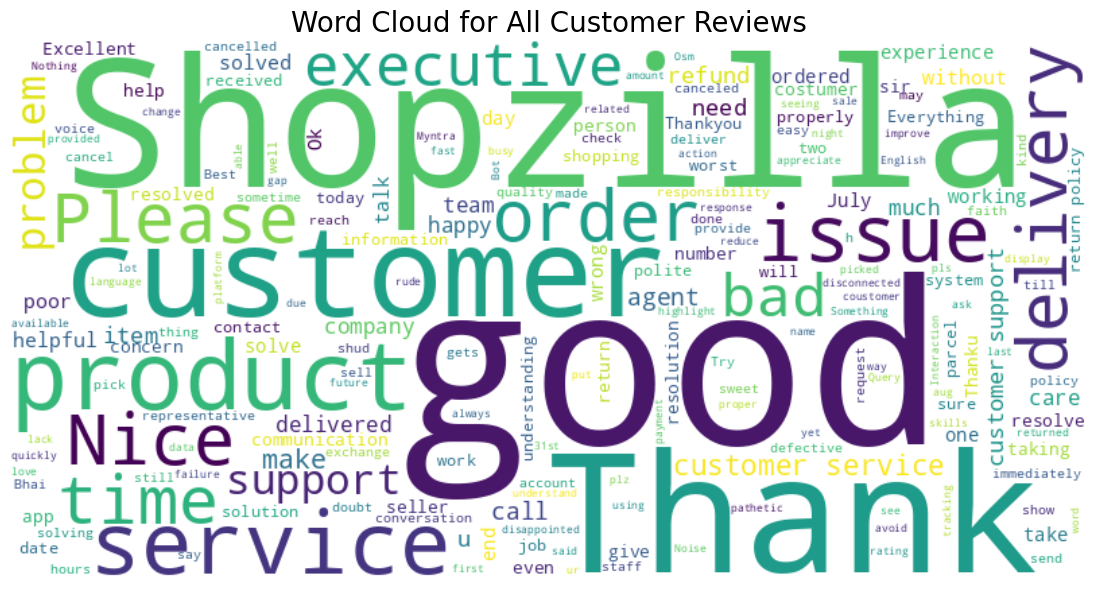

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd


# Combine all customer remarks into one string
text = ' '.join(df['Customer Remarks'].dropna().astype(str).tolist())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot it
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for All Customer Reviews", fontsize=20)

# Save the word cloud as an image file
wordcloud.to_file("customer_reviews_wordcloud.png")

plt.show()


🧠 You Can Also:
Create separate word clouds for positive, negative, or neutral sentiments:

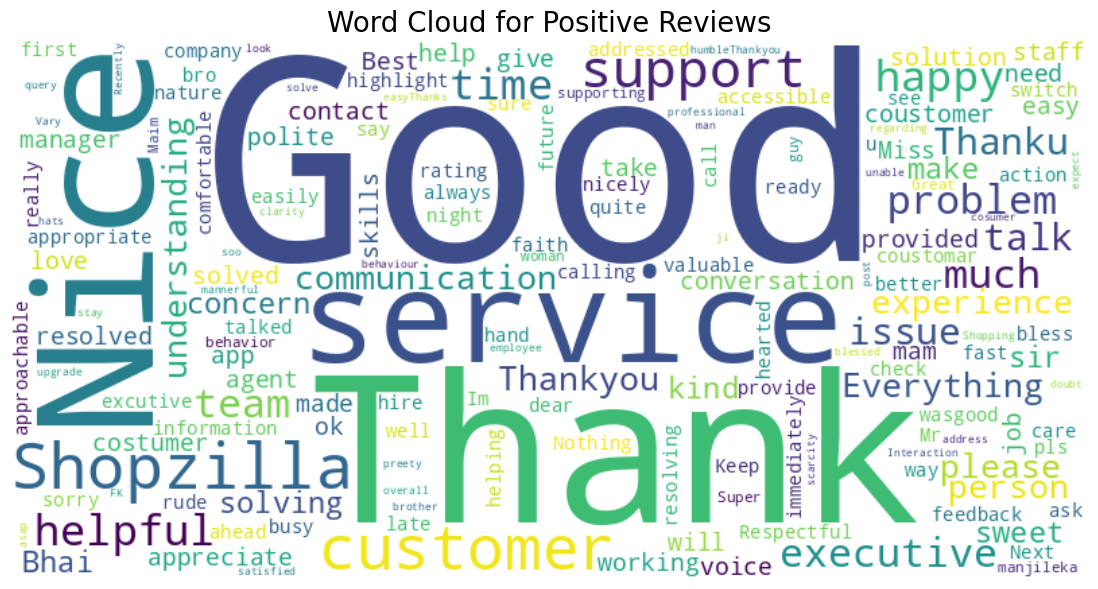

In [ ]:
# Word cloud for positive reviews (DistilBERT)
positive_text = ' '.join(df[df['Sentiment_Roberta'] == 'positive']['Customer Remarks'].dropna().astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Positive Reviews", fontsize=20)

# Save the word cloud as an image file
wordcloud.to_file("positive_reviews_wordcloud.png")

plt.show()


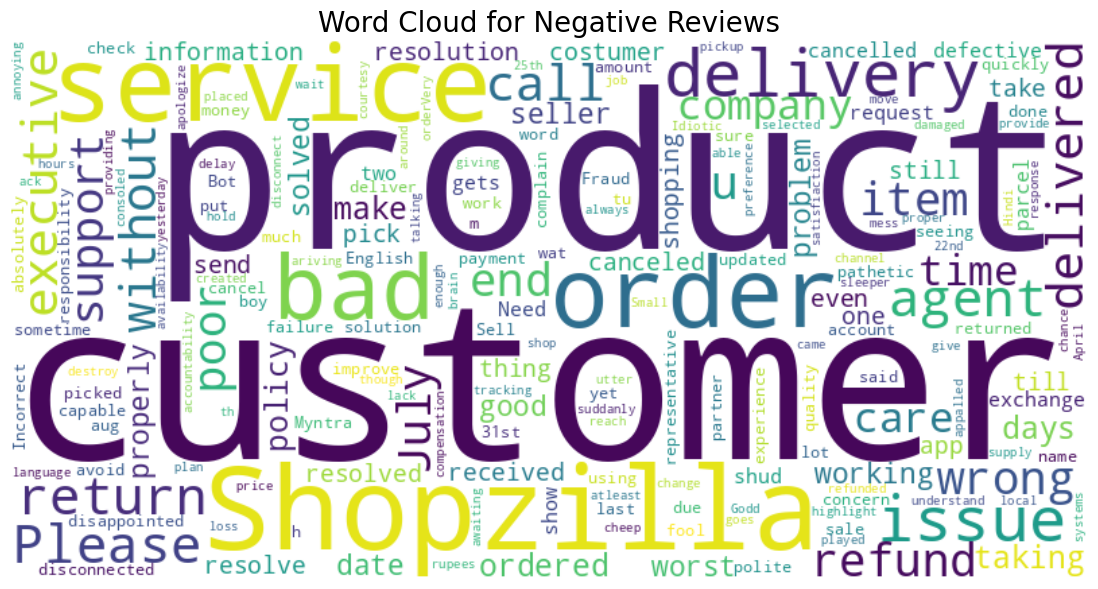

In [ ]:
# Word cloud for positive reviews (DistilBERT)
positive_text = ' '.join(df[df['Sentiment_Roberta'] == 'negative']['Customer Remarks'].dropna().astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Negative Reviews", fontsize=20)

# Save the word cloud as an image file
wordcloud.to_file("negative_reviews_wordcloud.png")
plt.show()

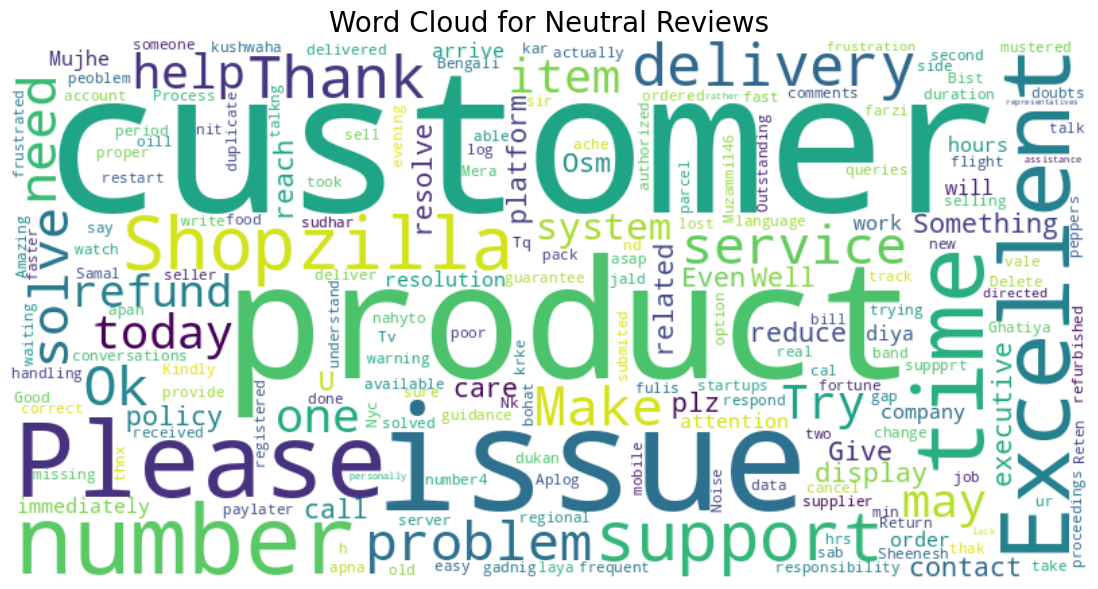

In [ ]:
# Word cloud for positive reviews (DistilBERT)
positive_text = ' '.join(df[df['Sentiment_Roberta'] == 'neutral']['Customer Remarks'].dropna().astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Neutral Reviews", fontsize=20)

# Save the word cloud as an image file
wordcloud.to_file("neutral_reviews_wordcloud.png")
plt.show()

✅ Circle Packing for Most Frequent Words (using Plotly):

In [41]:
import pandas as pd
from collections import Counter
import plotly.express as px
import re

# Preprocess and combine all customer remarks into one string
text = ' '.join(df['Customer Remarks'].dropna().astype(str).tolist()).lower()
text = re.sub(r'[^a-z\s]', '', text)  # remove punctuation and non-letters

# Tokenize and count word frequency
words = text.split()
stopwords = set([
    'the', 'and', 'to', 'is', 'in', 'it', 'for', 'of', 'on', 'this', 'that', 'with',
    'a', 'an', 'at', 'was', 'as', 'i', 'we', 'you', 'they', 'be', 'but', 'are', 'or', 'from'
])
filtered_words = [word for word in words if word not in stopwords and len(word) > 2]

# Count word frequencies
word_counts = Counter(filtered_words)
top_words = word_counts.most_common(50)  # top 50 words

# Create DataFrame for Plotly
circle_df = pd.DataFrame(top_words, columns=['name', 'value'])

# Create circle packing chart
fig = px.treemap(circle_df,
                 path=[px.Constant("words"), 'name'],
                 values='value',
                 color='value',
                 color_continuous_scale='blues',
                 title="Circle Packing of Top 50 Frequent Words")

# Update layout to mimic circular packing
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))

fig.show()


# Training our own sentiment analysis transformer from scratch (same as finetuning just we did before)

# **Selecting valuable Customer Reviews**
